# Trabajo Práctico 4: Redes

<p style="text-align: justify;">
En el marco de la materia optativa *Ciencia de Datos* estudiamos las técnicas de Teoría de Grafos a partir del análisis de la red de colaboraciones científicas mediante el paquete de Python [**networkx**](https://networkx.github.io/). En la [página web de la materia](http://www.dc.uba.ar/materias/cienciadatos) se encuentran disponibles los [datos](http://www.dc.uba.ar/materias/cienciadatos/tps/tp4/data.csv/view) utilizados, así como también las [referencias teóricas](http://www.dc.uba.ar/materias/cienciadatos/teoricas/teorica-Redes.pdf/view) y la [guía](http://www.dc.uba.ar/materias/cienciadatos/tps/tp4/Redes.pdf/view) para el desarrollo de los análisis correspondientes. <br>

<p style="text-align: justify;">
En el presente trabajo se analiza la red de colaboraciones científicas de publicaciones de física de altas energías del repositorio
ArXiv como una red compleja. 
</p> 

## Tabla de Contenidos 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [0. Datos](#datos)
    - [0.1. Imports](#paquetes)  
    - [0.2. Carga y limpieza de datos](#limpieza)  
- [1. Creación del grafo](#grafo)
- [2. Distribución de grado](#grado)
- [3. Componentes conexas](#componentes)
- [4. Tamaños de vecindades](#vecindades)
- [5. Mundos pequeños](#mundospequeños)
- [6. Estrellas](#estrellas)
<!-- /MarkdownTOC -->

<a name="datos"></a>
## 0. Datos

<p style="text-align: justify;">
El archivo `data.csv` contiene una lista de publicaciones de física de altas energías del repositorio ArXiv. En esta práctica vamos a estudiar el grafo de colaboraciones entre autores, en el que los nodos representan autores y las aristas coautorías. Vamos a usar un grafo simple no dirigido, en el que basta una coautoría para que haya una conexión entre dos autores.
</p> 

<a name="paquetes"></a>
## 0.1. Imports

<p style="text-align: justify;">
Cargamos los paquetes de Python a utilizar.
</p> 

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import pickle
import itertools
import networkx as nx
import collections 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os.path
import random 

/home/stella/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a name="limpieza"></a>
## 0.2. Carga y limpieza de datos

#### Levantamos los datos del csv

Para cada publicación se cuenta con el año, un código relacionado con la revista y el tema, la revista, los autores y el título.

In [3]:
with open('data.csv', 'r') as f:
    rows = [[c.strip() for c in l.split(',', 4)]
             for l in f]


In [4]:
papers = pd.DataFrame(rows, columns=['year', 'id', 'journal', 'authors', 'title'])

In [5]:
papers.head()

,year,id,journal,authors,title
0,1992,B368,Nucl.Phys.,Horne & Horowitz,Exact Black String Solutions in Three Dimensions
1,1992,B278,Phys. Lett.,Mikovic,Hamiltonian construction of W-gravity actions
2,1991,A6,Mod. Phys. Lett.,Huitu & Nemeschansky,Supersymmetric Gelfand-Dickey Algebra
3,1992,B373,Nucl.Phys.,Witten,Ground Ring Of Two Dimensional String Theory
4,1991,A6,Mod.Phys.Lett.,Intriligator,Fusion Residues


####  Limpiamos los datos

En una primera inspección de la tabla de datos se observa que para ciertos casos la información provista ó bien no está ordenada correctamente ó está incompleta ó hay demás. Se filtraron estos casos y se continúa con la generación del grafo.

In [16]:
[ j for j in range(len(papers['year'])) if len(papers['year'][j]) != 4]

[1255, 6167, 6397, 6398]

In [17]:
papers.loc[1255]

year                                        Kluwer Ac. Publ.
id                                           Dordrecht 1994)
journal                                                 Vol.
authors                                     Lousto & Sanchez
title      The Quantization of the Spacetime Geometry Gen...
Name: 1255, dtype: object

In [18]:
papers['year'][1255]

'Kluwer Ac. Publ.'

In [19]:
[j for j in range(len(papers['authors'])) if len(papers['authors'][j]) == 0]

[6166]

In [20]:
papers['authors'][6166]

''

In [21]:
papers.loc[6166]

year                                                    1995
id                                                      B349
journal    lectures in Formation and Interactions of Topo...
authors                                                     
title                                                   None
Name: 6166, dtype: object

In [31]:
papers_copy = papers
papers_copy = papers_copy.drop(papers_copy.index[6166])

In [32]:
papers_copy.iloc[6166]

year                                           NATO ASI B349
id                                            ed A.-C. Davis
journal                                                   R.
authors                                               Carter
title      Dynamics of Cosmic Strings and other Brane models
Name: 6167, dtype: object

In [33]:
papers.iloc[6167]

year                                           NATO ASI B349
id                                            ed A.-C. Davis
journal                                                   R.
authors                                               Carter
title      Dynamics of Cosmic Strings and other Brane models
Name: 6167, dtype: object

In [34]:
[j for j in list(papers_copy.index) 
 if not (papers_copy['authors'][j].title()[0] == papers_copy['authors'][j][0]
         or papers_copy['authors'][j][0] == 'd')]

[6397, 7127]

In [36]:
[papers_copy.loc[j] for j in list(papers_copy.index) 
 if not (papers_copy['authors'][j].title()[0] == papers_copy['authors'][j][0]
         or papers_copy['authors'][j][0] == 'd')]

[year                                 Geometry
 id                        Groups and Algebras
 journal                                vol. 2
 authors    eds. H.-D. Doebner e.a. World Sci.
 title                                        
 Name: 6397, dtype: object,
 year                                                    1997
 id                                                      B414
 journal                                           Phys.Lett.
 authors                                       karra & Rivers
 title      Initial Vortex Densities after a Temperature Q...
 Name: 7127, dtype: object]

In [37]:
papers.loc[6397], papers.loc[7127]

(year                                 Geometry
 id                        Groups and Algebras
 journal                                vol. 2
 authors    eds. H.-D. Doebner e.a. World Sci.
 title                                        
 Name: 6397, dtype: object,
 year                                                    1997
 id                                                      B414
 journal                                           Phys.Lett.
 authors                                       karra & Rivers
 title      Initial Vortex Densities after a Temperature Q...
 Name: 7127, dtype: object)

In [6]:
banned_indexs = [2114, 6166, 6167, 6396, 6397, 6398, 7189]

In [7]:
papers.loc[banned_indexs]

,year,id,journal,authors,title
2114,1994,B328,Phys.Lett.,Nikolaev & Zakharov & IKP & Juelich & Juelich ...,The spectrum and solutions of the generalized ...
6166,1995,B349,lectures in Formation and Interactions of Topo...,,None
6167,NATO ASI B349,ed A.-C. Davis,R.,Carter,Dynamics of Cosmic Strings and other Brane models
6396,1997,P21,GROUP21,Physical Applications and Mathematical Aspects of,None
6397,Geometry,Groups and Algebras,vol. 2,eds. H.-D. Doebner e.a. World Sci.,
6398,Singapore,1997) p.,Kanatchikov,Novel algebraic structures from the polysymple...,None
7189,1998,E57,Phys.Rev.,Caiani & Casetti & Clementi & Pettini & Pettin...,Geometry of dynamics and phase transitions in ...


In [8]:
papers = papers.drop(papers.index[banned_indexs])

In [9]:
papers.to_csv('data.limpia.csv')

<a name="grafo"></a>
## 1. Creación del grafo

#### Extraemos todos los autores

In [10]:
papers = pd.read_csv('data.limpia.csv')

In [11]:
def authors_from_text(text):
    "Devuelve la lista de autores de texto como 'A & B & C'"
    s = text.split('&')
    return [x.strip() for x in s]

In [12]:
authors = [author
           for text in papers['authors']
           for author in authors_from_text(text)]

#### Extraemos las coautorías

In [13]:
co_authors = [list(itertools.combinations(set(authors_from_text(authors)), 2))
              for authors in papers['authors']]
co_authors = [x for x in co_authors if len(x) != 0]
co_authors = [co_autoria 
              for co_autorias in co_authors
              for co_autoria in co_autorias]

#### Creamos el grafo

In [14]:
grafo_citas = nx.Graph()

In [15]:
grafo_citas.add_nodes_from(authors)

In [16]:
grafo_citas.add_edges_from(co_authors)

    OJO QUE QUEDARON ALGUNAS COSAS SIN LIMPIAR

In [17]:
grafo_citas['pages']

{'Banerjee': {}, 'KANAZAWA-94-01': {}, 'Kubo': {}, 'LaTeX': {}, 'Rothe': {}}

In [18]:
grafo_citas['LaTeX']

{'Banerjee': {}, 'Rothe': {}, 'pages': {}}

In [59]:
grafo_citas['KANAZAWA-94-01']

AtlasView({'Kubo': {}, 'pages': {}})

La cantidad de nodos y eje que forman el grafo son:

In [19]:
print('# de nodos: {}'.format(len(grafo_citas.nodes())))
print('# de ejes: {}'.format(len(grafo_citas.edges())))

# de nodos: 4003
# de ejes: 7782


In [21]:
pos = nx.drawing.spring_layout(grafo_citas)

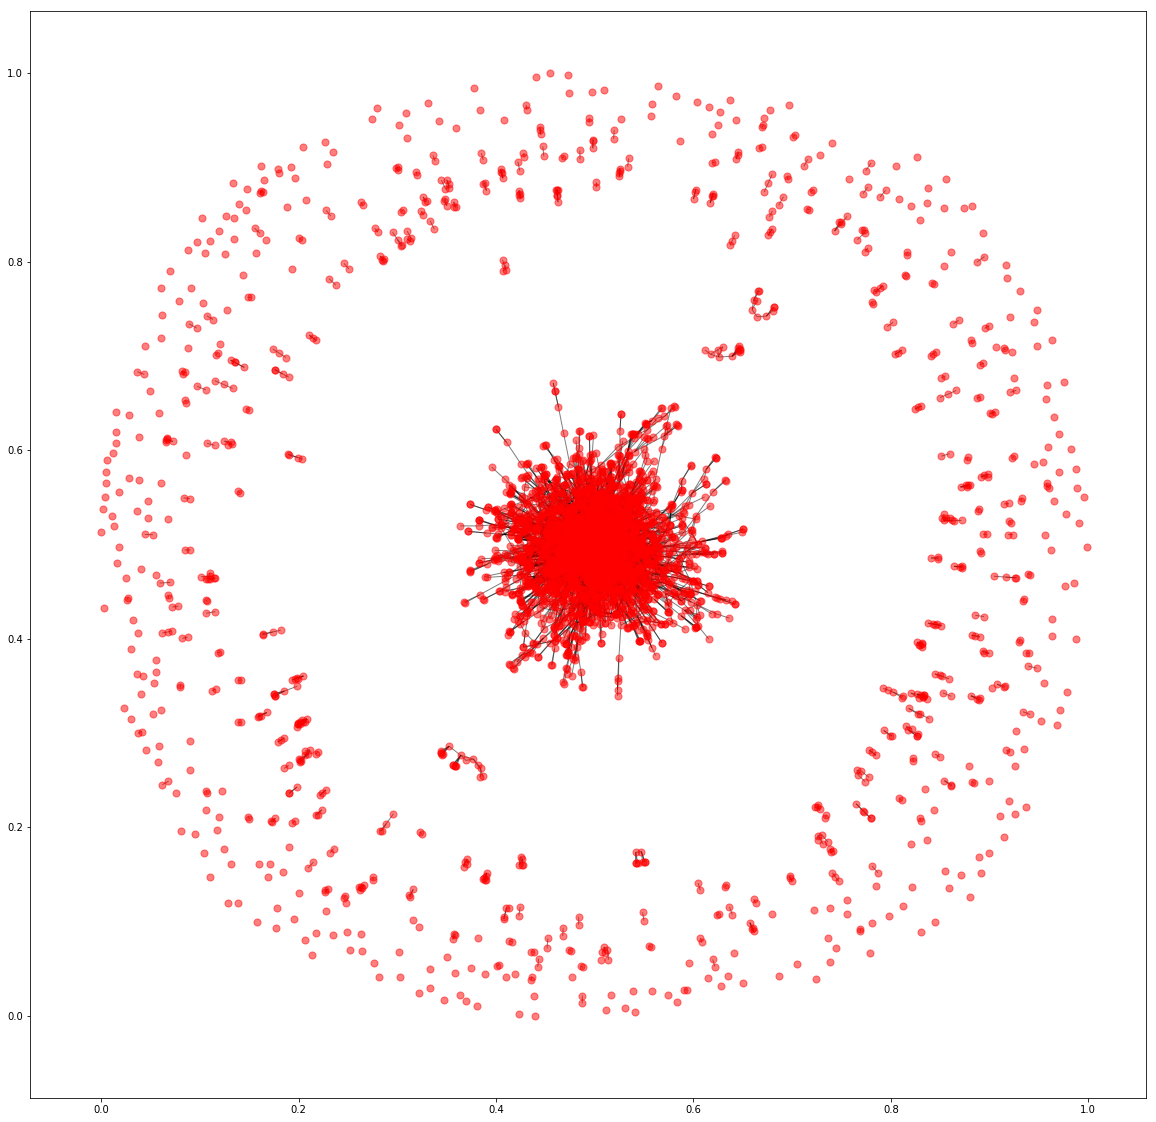

In [22]:
plt.figure(figsize(20, 20))
nx.draw_networkx(grafo_citas, pos, with_labels=False, node_size=50, alpha=0.5)

En el grafo se observa una gran cantidad de nodos centrales y conectados entre sí, formando una suerte de subconjunto. A su alrededor se disponen aquellos nodos sin conexiones o con pocas (~5).

A continuación se emplean herramientas específicas para caracterizar el grafo y el comportamiento de sus partes.

<a name="grado"></a>
##  2. Distribución de Grado

Para comenzar con la descripción del grafo se estudiará la distribución de grado de cada nodo.

In [23]:
def get_degree_values(G):
    #degree_values = [list(G.degree())[x][1] for x in range(len(G.degree()))]
    degree_values = [len(nbrs) for n,nbrs in G.adj.items()]
    return degree_values

In [24]:
deg = get_degree_values(grafo_citas)
count = collections.Counter(sorted(deg))


Se grafica la distribución de grados de nodos en diferentes escalas para decidir cuál es la más apropiada en este caso.

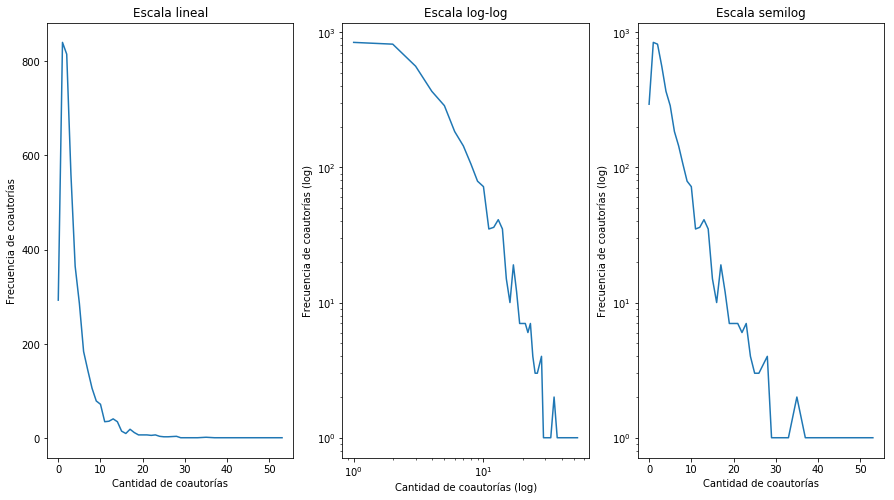

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
xs = list(count.keys())
ys = list(count.values())

sca(axs[0])
plot(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías')
title('Escala lineal')

sca(axs[1])
loglog(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías (log)')
ylabel('Frecuencia de coautorías (log)')
title('Escala log-log')

sca(axs[2])
semilogy(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías (log)')
title('Escala semilog')
plt.show()

Eliminamos las colas (vemos hasta 30 co-autorías y eliminamos los autores sin co-autorías)

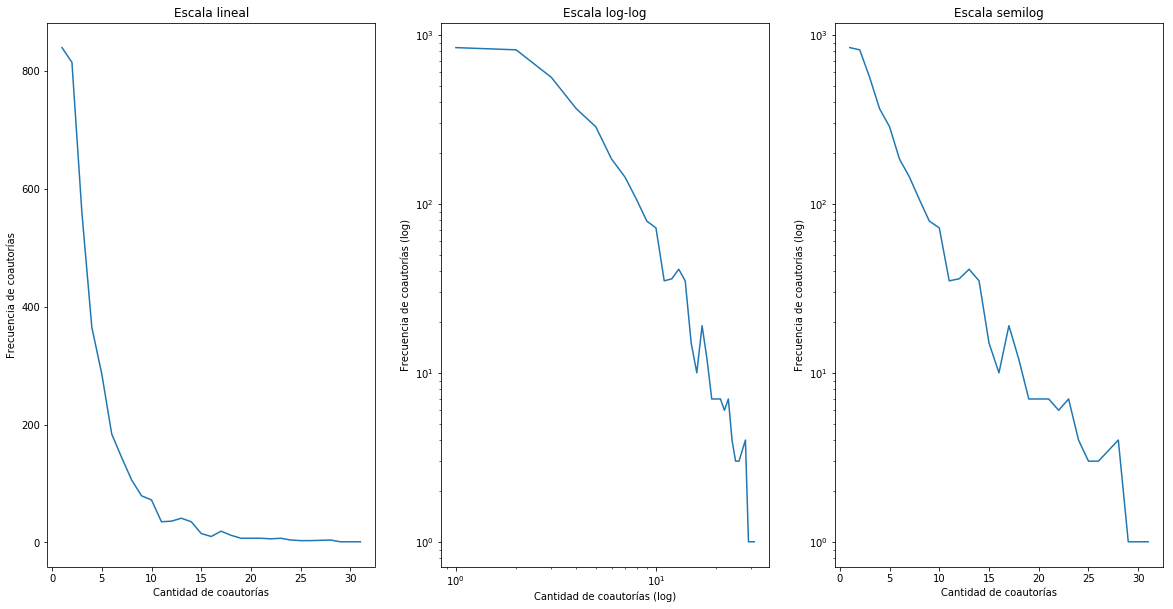

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
sca(axs[0])
plot(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías')
title('Escala lineal')

sca(axs[1])
loglog(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías (log)')
ylabel('Frecuencia de coautorías (log)')
title('Escala log-log')

sca(axs[2])
semilogy(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías (log)')
title('Escala semilog')
plt.show()

Vale recordar que si es una escala logarítmica en ambos ejes la que mejor representa los datos estamos en presencia de una distribución del tipo Ley de potencias mientras que si la escala logarítmica es representativa sólo en el eje $y$ la distribución es exponencial. Teniendo en cuenta que con una inspección cualitativa no se puede elegir con seguridad si estamos en presencia de un caso o el otro, realizamos un ajuste lineal y se reporta el valor de $R^2$ para ambos casos.

In [27]:
exp_rs = sm.OLS(np.log(ys[1:]), xs[1:]).fit()
print('Exp R^2: {:.4f}'.format(exp_rs.rsquared))
power_rs = sm.OLS(np.log(ys[1:]), np.log(xs[1:])).fit()
print('Power-law R^2: {:.4f}'.format(power_rs.rsquared))

Exp R^2: 0.1372
Power-law R^2: 0.3329


En ninguno de los dos ajustes se obtiene un resultado contundente en cuanto a la linealidad del gráfico anailzado. Sin embargo, el valor de $R^2$ obtenido para el caso de la ley de potencias es mayor, por lo que en caso de ser necesario, se tomará este resultado.

<a name="componentes"></a>
##  3. Componentes conexas

En esta sección se quiere estudiar si la red está completamente conectada y de no ser así, se busca caracterizar, a través de su tamaño y frecuencia de aparición, los subgrupos que puedan formarse dentro del grafo original. El mayor de estos subconjuntos se denominada "componente conexa gigante".

In [28]:
nx.is_connected(grafo_citas)

False

In [29]:
nx.number_connected_components(grafo_citas)
print('Cantidad de componentes conexas: {}'.format(nx.number_connected_components(grafo_citas)))

Cantidad de componentes conexas: 530


In [30]:
components = list(nx.connected_components(grafo_citas))
subgrafo_citas = list(nx.connected_component_subgraphs(grafo_citas))

#### Componente gigante

Se define y grafica la componente gigante del grafo

In [31]:
# sorted
components_sorted = sorted(subgrafo_citas, key=len, reverse=True)
giant_component = components_sorted[0]
print('Cantidad de nodos: {}'.format(len(giant_component.nodes())))
print('Cantidad de ejes: {}'.format(len(giant_component.edges())))

Cantidad de nodos: 3016
Cantidad de ejes: 7147


In [32]:
components_id = list(enumerate(components))  # :: [(id, componente)]
node_to_id = dict([(nodo, id_componente)  # :: nodo -> id_componente
                   for id_componente, nodos_componentes in components_id
                   for nodo in nodos_componentes])
nodes_ids = [node_to_id[n] for n in grafo_citas.nodes()]  # [id_componente] para cada nodo

In [33]:
nx.is_connected(giant_component)

True

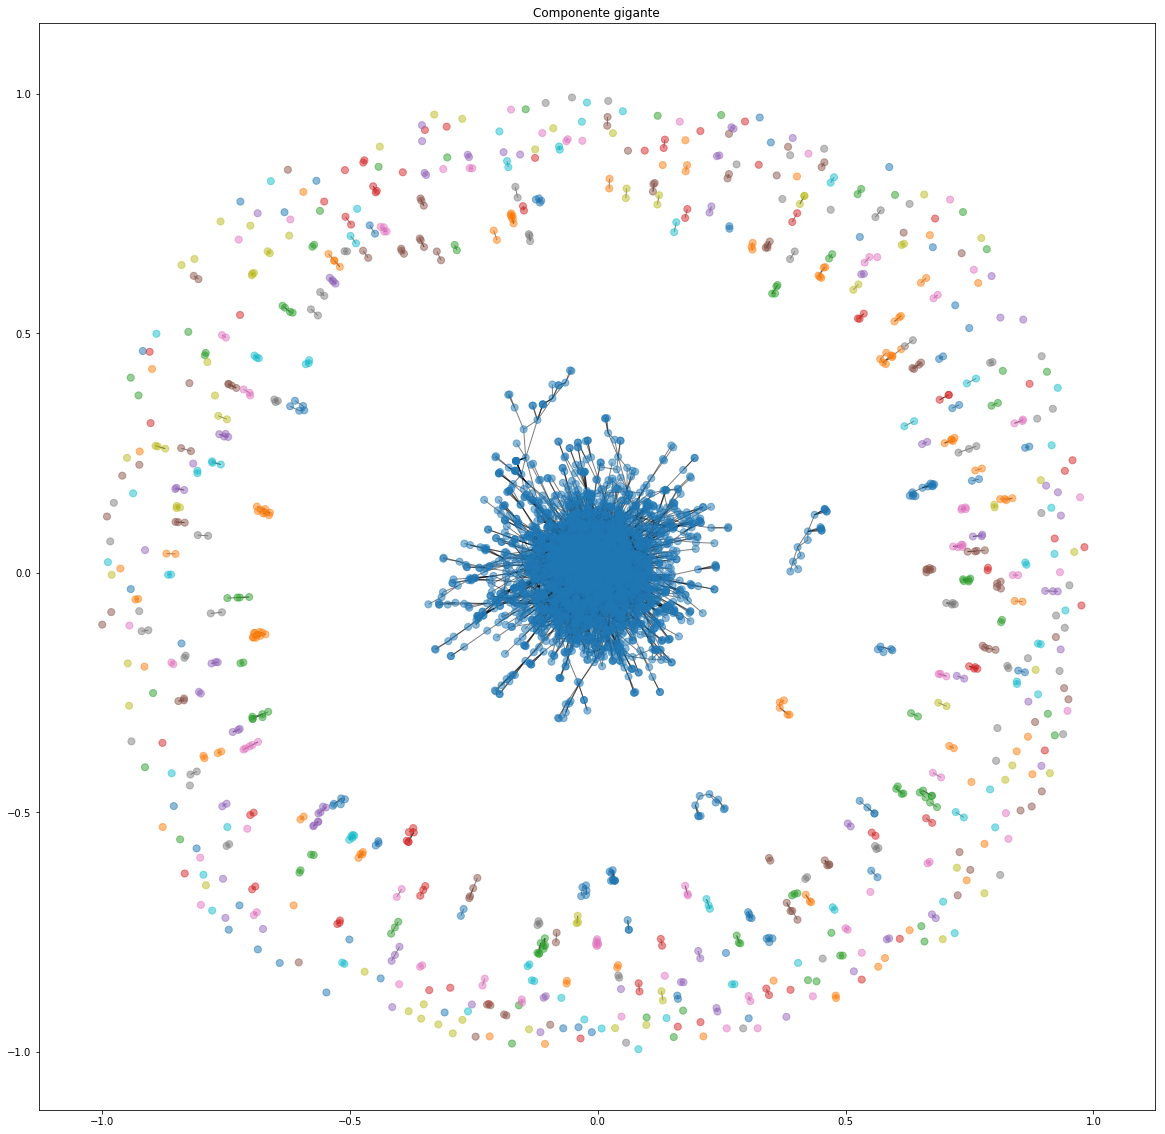

In [30]:
plt.figure(figsize(20, 20))
nx.draw_networkx(grafo_citas, pos=pos, node_size=50, alpha=0.5, 
                 node_color=nodes_ids, with_labels=False, cmap=cm.tab10)
title('Componente gigante')
plt.show()

En el gráfico se observa la componente gigante del grafo en color azul compuesta por 3016 nodos de los 4003 totales y 7147 ejes de 7782. Tal como se esperaba, aquí es donde se encuentra la mayor densidad de nodos y enlaces describiendo una fuerte interacción en las publicaciones de los autores correspondientes. Esto coincide con lo observado y reportado en la primer representación del grafo como el "subconjunto central" de nodos.

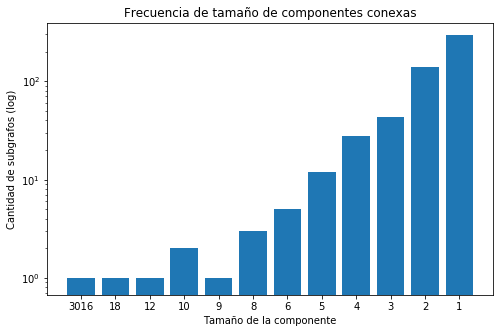

In [34]:
components_sizes = [len(c) for c in components]
c = collections.Counter(components_sizes)
xs = sorted(c.keys(), reverse=True)
ys = [c[x] for x in xs]
figure(figsize=(8, 5))
bar(range(len(xs)), ys, tick_label=xs, log=True)
title('Frecuencia de tamaño de componentes conexas')
xlabel('Tamaño de la componente')
_ = ylabel('Cantidad de subgrafos (log)')

Por último, en este histograma se muestra la frecuencia del tamaño de las diferentes componentes conexas que integran el grafo. Como ya fue observado anteriormente hay una única componente gigante de 3016 nodos mientras que componentes de un único nodos hay del orden de 100, es decir ~100 del total de los nodos están no conectados. La próxima componente de mayor tamaño posee solamente 18 nodos y la sigue una de 12. Como era de esperarse a partir de la visualización anterior del grafo, el mayor número de componentes conexas poseen pocos nodos (=< 8) lo que significa que, sin considerar la componente gigante, la mayoría de los autores tienen publicaciones con un grupo reducido de colegas.

<a name="vecindades"></a>
##  4. Tamaños de vecindades

En este caso se quiere ver, cómo a partir de cierto nodo de la componente gigante y alejándose del mismo, se agregan nodos nuevos. Es decir se evalúa cómo cierto nodo está conectado con sus vecinos y cuántos pasos debo realizar para llegar de un nodo a otro.

In [32]:
def roberto_carlos(G, nodo_inicial):
    """
    Calcula el esparcimiento en el grafo a partir del nodo inicial.
    
    Args:
        G: Grafo inicial
        nodo_inicial: nodo del grafo a partir del cual se calcula esparcimiento
        
    Return:
        {
            'visitados': nodos visitados en cada paso,
            'agregados': nodos agregados en cada paso
        }
    """
    por_ver = set([nodo_inicial])
    vistos = set()
    visitados = []
    agregados = []
    while len(por_ver) > 0:
        proximos = set([vecino
                        for n in por_ver
                        for vecino in G[n]])
        por_ver = proximos - vistos
        agregados.append(len(por_ver))
        vistos = vistos | proximos
        visitados.append(len(vistos))
        
    return {
        'visitados': visitados,
        'agregados': agregados
    }

In [33]:
elegidos_gigante = random.choice(giant_component.nodes(), size=30, replace=False)

In [34]:
df = pd.DataFrame.from_records(
    [roberto_carlos(giant_component, n) for n in elegidos_gigante]
)

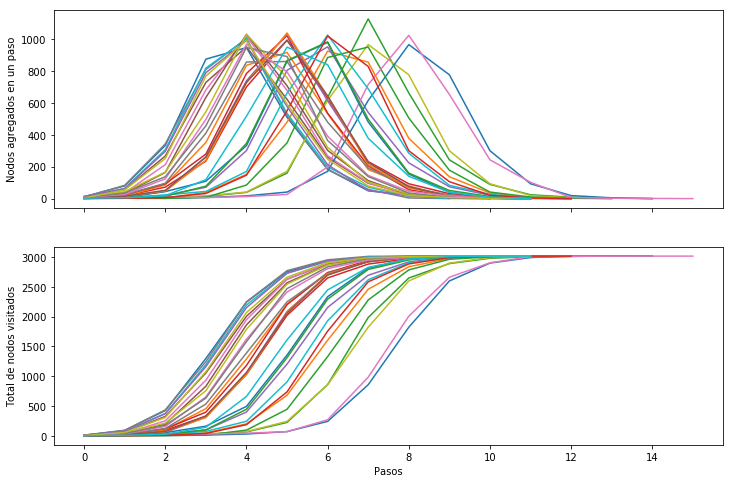

In [35]:
fig, axs = subplots(2, 1, figsize=(12, 8), sharex=True)
sca(axs[0])
for agregados in df['agregados']:
    plot(range(len(agregados)), agregados)
    
ylabel('Nodos agregados en un paso')

sca(axs[1])
for visitados in df['visitados']:
    plot(range(len(visitados)), visitados)
    
ylabel('Total de nodos visitados')
    
xlabel('Pasos')
plt.show()

En el primer gráfico, se muestran los nodos agregados en cada paso, es decir al visitar un nodo nuevo, éste se encuentra conectado con otros.....

En el segundo gráfico se presenta el total de nodos visitados en cada paso....

CONTINUAR

<a name="mundospequeños"></a>
##  5. Mundos pequeños

Calculamos el coeficiente de clustering promedio de la componente gigante del grafo.

In [35]:
cc = nx.clustering(giant_component)

In [36]:
cc_list = list(cc.values())
mean(cc_list)

0.47861863375943958

In [37]:
average_cc = nx.average_clustering(giant_component)
average_cc

0.4786186337594396

Calculamos el camino mínimo medio.

In [38]:
nx.average_shortest_path_length(giant_component)

6.0536554627393535

<p style="text-align: justify;">
Para analizar si las métricas obtenidas muestran una topología no trivial del grafo como por ejemplo propiedades de mundo pequeño, las comparamos con las medidas obtenidas para un grafo aleatorio con la misma distribución de grado.
</p>

### Red de topología random preservando la distribución de grado de la red original

In [39]:
def randomize_by_edge_swaps(G, num_iterations=10):
    """
    Randomiza una red preservando su distribución de grados. Para esto selecciona 2 pares de nodos conectados e intercambia sus ejes.
    Es decir, agarra A-B y C-D e intercambia las conexiones de manera tal que quedan A-D y C-B.
    Esquema:
         A   C
         |* *|           | par de ejes seleccionados
         | * |
         |* *|           * par de ejes nuevos
         B   D
    Para hacer este intercambio, el algoritmo:
        - admite previamente el troque del orden de los nodos del eje
        - se fija que luego del intercambio de ejes no queden self-loops
        - se fija que luego del intercambio de ejes no queden ejes repetidos
    
    Args:
        G: Grafo inicial
        num_iterations: numero de veces que recorre aleatoriamente un total de ejes igual al del grafo inicial y realiza el intercambio de conexiones entre pares de nodos si se cumplen las condiciones necesarias para el intercambio (por default usa num_iterations=10)
        
    Return:
        {
            G_random: Grafo randomizado preservando la distribución de grados del grafo inicial
        }
    
    Packages:
        random
        networkx
    """
    G_random = G.copy()
    #edge_list = G_random.edges() #v1.1
    edge_list = list(G_random.edges()) #v2.0
    num_edges = len(edge_list)
    total_iterations = num_edges * num_iterations

    executed_iterations = []
    for i in range(total_iterations):
        rand_index1 = int(round(random.random() * (num_edges - 1)))
        rand_index2 = int(round(random.random() * (num_edges - 1)))
        original_edge1 = edge_list[rand_index1]
        original_edge2 = edge_list[rand_index2]
        head1, tail1 = original_edge1
        head2, tail2 = original_edge2

        # Permito la posibilidad de intercambiar el orden de los nodos del 1er eje con probabilidad random
        if random.random() >= 0.5:
            head1, tail1 = tail1, head1

        # Condición para no considerar self-loops
        if head1 == tail2 or head2 == tail1:
            continue

        # Condición para no agregar un eje que ya existe
        if G_random.has_edge(head1, tail2) or G_random.has_edge(
                head2, tail1):
            continue

        # Hago el intercambio de ejes
        original_edge1_data = G_random[head1][tail1]
        original_edge2_data = G_random[head2][tail2]

        G_random.remove_edges_from((original_edge1, original_edge2))

        new_edge1 = (head1, tail2, original_edge1_data)
        new_edge2 = (head2, tail1, original_edge2_data)
        G_random.add_edges_from((new_edge1, new_edge2))

        edge_list[rand_index1] = (head1, tail2)
        edge_list[rand_index2] = (head2, tail1)
        
        executed_iterations.append(i)

    #print('# de ejes intercambiados: {}'.format(len(executed_iterations)))
    #print('# de iteraciones: {}'.format((num_edges * num_iterations)))
    #print('# de ejes del grafo: {}'.format(num_edges))
    assert len(G_random.edges()) == num_edges
    return G_random


In [40]:
grafo_citas_random = randomize_by_edge_swaps(grafo_citas)

In [41]:
nx.number_connected_components(grafo_citas_random)

319

In [42]:
# identify largest connected component
components_sorted_random = sorted(nx.connected_component_subgraphs(grafo_citas_random), key=len, reverse=True)
giant_component_random = components_sorted_random[0]

In [43]:
print('Cantidad de nodos: {}'.format(len(giant_component_random.nodes())))
print('Cantidad de ejes: {}'.format(len(giant_component_random.edges())))

Cantidad de nodos: 3652
Cantidad de ejes: 7749


In [44]:
nx.average_clustering(giant_component_random)

0.002322170541238821

In [45]:
nx.average_shortest_path_length(giant_component_random)

5.098370474502777

Evaluamos distintos métodos para randomizar el grafo.

In [46]:
def randomize_by_rewiring(G):
    """
    Randomiza una red preservando su distribución de grados. Para esto arma una lista de todos los extremos de las conexiones,
    dejando repetidos los que aparecen en varios ejes, y recablea considerando:
        - que no queden self-loops
        - que no queden ejes repetidos
    
    Args:
        G: Grafo inicial
        
    Return:
        {
            G_random: Grafo randomizado preservando la distribución de grados del grafo inicial
        }
    
    Packages:
        random
        networkx
        numpy as np
        collections
    """
    #edge_list = G.edges() #v1.1
    edge_list = list(G.edges()) #v2.0
    edges = set( [tuple(e) for e in edge_list ]) 
    
    stubs = [ ]
    [ stubs.extend(e) for e in edges ]
    
    stub_counter = collections.Counter(stubs)

    new_edges = set()

    #nodes = np.array([ stub for stub,count in stub_counter.iteritems() if count!=0 ]) #Python2
    nodes = np.array([ stub for stub,count in stub_counter.items() if count!=0 ]) #Python3

    while len(nodes)>0:

        # valores iniciales para nuevos ejes
        first,second = -1,-1

        # elige ejes que no sean self-loops
        while first == second and len(nodes)>1:
            first,second = np.random.choice(nodes,size=(2,),replace=False)

        # agrego el eje mientras no sea self-loop, ni ya esté en el nuevo grafo recableado
        if first!=second and \
           (first,second) not in new_edges and \
           (second,first) not in new_edges and \
           len(nodes)>1:
            new_edges.add((first,second))
            stub_counter[first] -= 1
            stub_counter[second] -= 1
        else:
            # si no, elige un eje aleatoriamente y vuelve a poner sus nodos para futuras selecciones
            edge = random.sample(new_edges,1)[0]
            new_edges.remove(edge)
            stub_counter[edge[0]] += 1
            stub_counter[edge[1]] += 1

        # actualizo nodes
        nodes = np.array([ stub for stub,count in stub_counter.items() if count!=0 ])

    G_random = nx.Graph()
    G_random.add_nodes_from(list(G.nodes))
    G_random.add_edges_from(list(new_edges))
    
    return G_random


Definimos otros métodos de randomización aplicando funciones del paquete **networkx**.

In [47]:
def nx_double_edge_swap(G):
    grafo_citas_random = nx.double_edge_swap(G, 5000,10000)
    return grafo_citas_random

In [48]:
def nx_configuration_model_cleaned(G):
    grafo_citas_random = nx.configuration_model(get_degree_values(G))
    # remuevo links repetidos
    grafo_citas_random = nx.Graph(grafo_citas_random)
    # remuevo self-loops
    grafo_citas_random.remove_edges_from(grafo_citas_random.selfloop_edges())
    return grafo_citas_random

In [49]:
def nx_expected_degree_graph(G):
    grafo_citas_random = nx.expected_degree_graph(get_degree_values(G), selfloops=False)
    return grafo_citas_random

In [50]:
def nx_random_degree_sequence_graph(G):
    grafo_citas_random = nx.random_degree_sequence_graph(get_degree_values(G))
    return grafo_citas_random

In [51]:
randomize_methods = collections.OrderedDict({
    'randomize_by_edge_swaps': randomize_by_edge_swaps,
    'randomize_by_rewiring': randomize_by_rewiring,
    'nx_double_edge_swap': nx_double_edge_swap,
    'nx_configuration_model_cleaned': nx_configuration_model_cleaned,
    'nx_expected_degree_graph': nx_expected_degree_graph,
    'nx_random_degree_sequence_graph': nx_random_degree_sequence_graph
})

In [52]:
grafo_citas_random = collections.OrderedDict(
    [(k, method(grafo_citas)) for k, method in randomize_methods.items()]
    )

TypeError: 'method' object is not iterable

In [78]:
[nx.number_connected_components(G_random) for G_random in grafo_citas_random.values()]

[319, 367, 354, 316, 3970, 321]

In [96]:
nodes_giant_component_random = []
links_giant_component_random = []
cc_giant_component_random = []
d_giant_component_random = []
for G_random in grafo_citas_random.values():
    components_sorted_random = sorted(nx.connected_component_subgraphs(G_random), key=len, reverse=True)
    giant_component_random = components_sorted_random[0]
    nodes_giant_component_random.append(len(giant_component_random.nodes()))
    links_giant_component_random.append(len(giant_component_random.edges()))
    cc_giant_component_random.append(nx.average_clustering(giant_component_random))
    d_giant_component_random.append(nx.average_shortest_path_length(giant_component_random))
    #tabla = {'Nodos': len(giant_component_random.nodes()), 'Links': len(giant_component_random.edges()),
    #             'CC': nx.average_clustering(giant_component_random), 'd': nx.average_shortest_path_length(giant_component_random)
    #        }
    

In [97]:
tabla = collections.OrderedDict({'Nodos': nodes_giant_component_random, 'Links': links_giant_component_random,
         'CC': cc_giant_component_random, 'L': d_giant_component_random
        })

In [98]:
pd.DataFrame(tabla, index=grafo_citas_random.keys())

,Nodos,Links,CC,L
randomize_by_edge_swaps,3657,7754,0.002807,5.096744
randomize_by_rewiring,3546,7691,0.002389,5.472855
nx_double_edge_swap,3588,7720,0.011931,5.118687
nx_configuration_model_cleaned,3665,7744,0.002301,5.113623
nx_expected_degree_graph,34,443,0.876363,1.224599
nx_random_degree_sequence_graph,3652,7751,0.002840,5.094527


Y me fijo como queda la distribución de grado de todos los métodos de randomización en comparación con la red original.

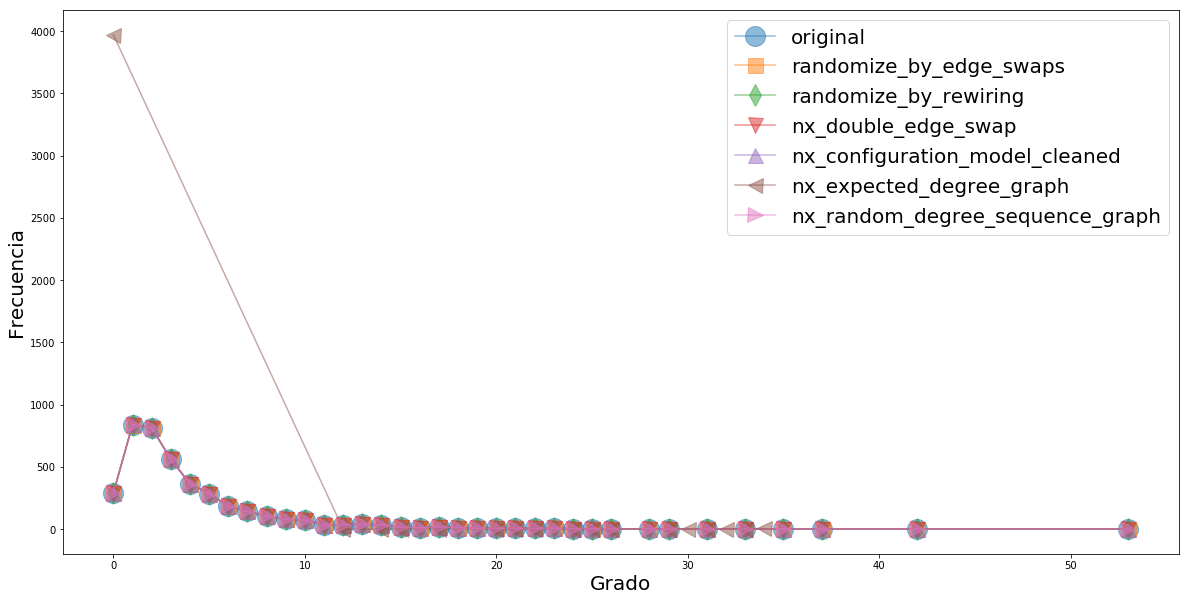

In [99]:
plt.figure(figsize(20, 10))
degrees = get_degree_values(grafo_citas)
count_degrees = collections.Counter(sorted(degrees))
plot(list(count_degrees.keys()), list(count_degrees.values()), label='original', alpha=0.5, marker='o', markersize=20)
markers = ['s','d','v','^','<','>']
i = 0
for name, G_random in grafo_citas_random.items():
    degrees_random = get_degree_values(G_random)
    count_degrees_random = collections.Counter(sorted(degrees_random))
    plot(list(count_degrees_random.keys()), list(count_degrees_random.values()), label=name, alpha=0.5, 
         marker=markers[i], markersize=15)
    i += 1
xlabel('Grado', size=20)
ylabel('Frecuencia', size=20)
legend(prop={'size': 20})
plt.show()

### Topología de la red original en comparación con la random

In [55]:
N = 10
CC_giant_component_random = []
L_giant_component_random = []
for n in range(N):
    G_random = randomize_by_edge_swaps(grafo_citas)
    components_sorted_random = sorted(nx.connected_component_subgraphs(G_random), key=len, reverse=True)
    giant_component_random = components_sorted_random[0]
    CC_giant_component_random.append(nx.average_clustering(giant_component_random))
    L_giant_component_random.append(nx.average_shortest_path_length(giant_component_random))


In [56]:
average_cc = nx.average_clustering(giant_component)
L = nx.average_shortest_path_length(giant_component)
cc_random_mean = np.mean(CC_giant_component_random)
cc_random_std = np.std(CC_giant_component_random)
L_random_mean = np.mean(L_giant_component_random)
L_random_std = np.std(L_giant_component_random)

In [149]:
print('\t Original \t | \t \t \t   Random')
print('--------------------------------------------------------------------------------')
print('CC: {} \t | \t {} +/- {}'.format(average_cc, cc_random_mean, cc_random_std))
print('L : {} \t | \t {} +/- {}'.format(L, L_random_mean, L_random_std))
#print('CC: {}'.format(average_cc))
#print('CC Random: {} +/- {}'.format(cc_random_mean, cc_random_std))
#print('L: {}'.format(L))
#print('L Random: {} +/- {}'.format(L_random_mean, L_random_std))

	 Original 	 | 	 	 	   Random
--------------------------------------------------------------------------------
CC: 0.4786186337594398 	 | 	 0.002749089032132743 +/- 0.0005227649911646457
L : 6.0536554627393535 	 | 	 5.098092481823785 +/- 0.00986502074075158


In [59]:
pd.DataFrame({'Original':{'CC': average_cc, 'L': L}, 'Random (mean)': {'CC': cc_random_mean, 'L': L_random_mean}, 'Random (std)':{'CC': cc_random_std, 'L': L_random_std}})

,Original,Random (mean),Random (std)
CC,0.478619,0.002775,0.000583
L,6.053655,5.102724,0.012332


<a name="estrellas"></a>
##  6. Estrellas

Por último, se busca identificar y estudiar el comportamiento de los nodos que están más conectados según algunas métricas de centralidad. 

Para llevarlo a cabo se decidió primeramente estudiar la centralidad de los nodos de la componente gigante a través de varias métricas. Luego, una vez identificado un nodo con alta centralidad se lo remueve y se observa el grafo resultante y cómo afecta esta remoción su tamaño. Haciendo varias iteraciones de este procedimiento, esto es eliminando varios nodos centrales elegidos para diferentes métricas, se estudia la evolución de tamaño y conexión de la componente gigante.

In [13]:
centrality_metrics = collections.OrderedDict({
    'degree': nx.degree_centrality,
    'eigen': nx.eigenvector_centrality,
    'closeness': nx.closeness_centrality,
    'betweeness': nx.betweenness_centrality
})

In [14]:
CENTRALITY_PKL = 'centrality_scores.pkl'
if not os.path.isfile(CENTRALITY_PKL):
    centrality_scores = collections.OrderedDict(
        [(k, metric(grafo_citas)) for k, metric in centrality_metrics.items()]
    )
    with open(CENTRALITY_PKL, 'wb') as f:
        pickle.dump(centrality_scores, f)
else:
    with open(CENTRALITY_PKL, 'rb') as f:
        centrality_scores = pickle.load(f)

In [15]:
percentile = .2

In [16]:
percentile_most_central = collections.OrderedDict(
    [(k, dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:int(len(scores) * percentile)]))
     for k, scores in centrality_scores.items()]
)

In [17]:
sizes = [sum([1 for centrals in percentile_most_central.values() if n in centrals])
         for n in grafo_citas.nodes()]
filtered_sizes = [s for s in sizes if s > 0]

1 366
2 356
3 198
4 382


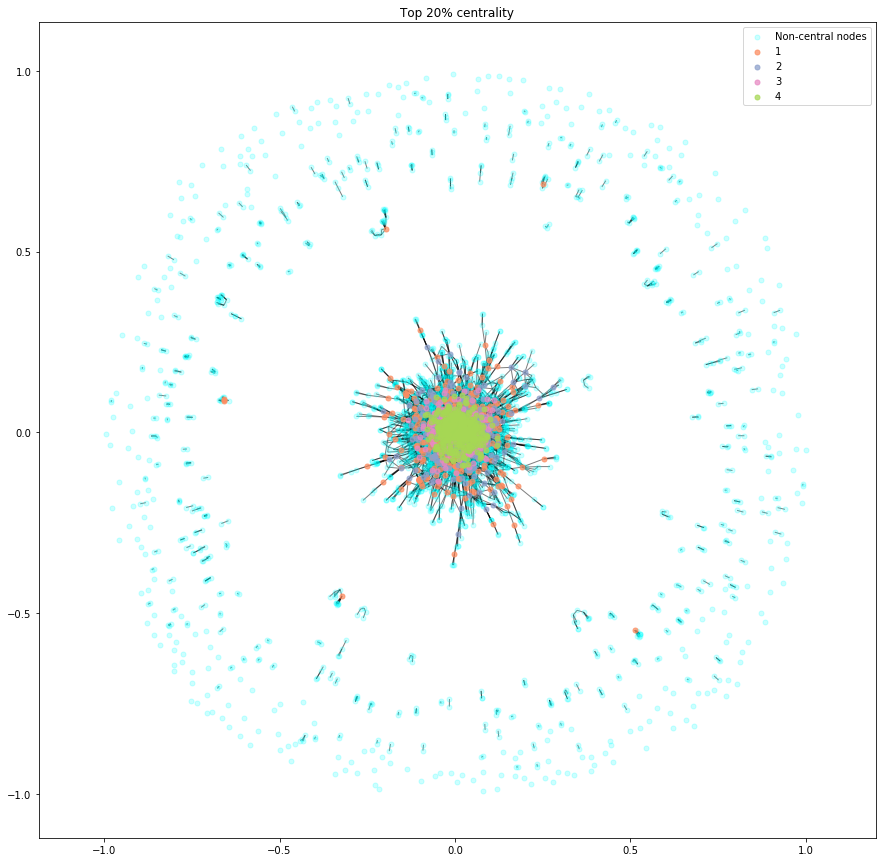

In [20]:
figure(figsize=(15, 15))
# pos = nx.layout.spring_layout(grafo_citas)
nx.draw_networkx_edges(grafo_citas, pos, alpha=0.5)

nx.draw_networkx_nodes(grafo_citas, pos, with_labels=False, node_size=25, 
                       nodelist=[n for n, s in zip(grafo_citas.nodes(), sizes) if s == 0],
                       node_color='cyan', alpha=0.2, label='Non-central nodes')

for size in range(1, 5):
    nl = [n for n, s in zip(grafo_citas.nodes(), sizes) if s == size]
    print(size, len(nl))
    nx.draw_networkx_nodes(grafo_citas, pos, with_labels=False, node_size=25, nodelist=nl, 
                           node_color=cm.Set2(size), alpha=0.75, label=str(size))
    
legend()
title('Top 20% centrality')
plt.show()

In [25]:
def plot_selectivity(centrality_scores, label=None):
    scores = np.array(centrality_scores)
    stops = np.linspace(max(centrality_scores), min(centrality_scores), 20)
    xs = np.linspace(0, 1, 20)
    ys = np.array([sum(scores > s) for s in stops]) / len(centrality_scores)
    plot(xs, ys, label=label)

In [26]:
figure(figsize=(10, 10))
for name, scores in centrality_scores.items():
    plot_selectivity(list(centrality_scores.values()), name)
xlabel('Selectividad (% rango)')
ylabel('% centrales')
title('Selectividad de métricas de centrality')
legend()
plt.show()

TypeError: '>' not supported between instances of 'dict' and 'dict'

In [27]:
def eliminamos_centros(G, centrality_scores, pasos):
    """
    Elimina nodos centrales sucesivamente y calcula el tamaño de la componente gigante.
    
    Args:
        G: grafo
        centrality_scores: diccionario nodo -> score centralidad
        pasos: cantidad de pasos a realizar
        
    Return:
        lista de tamaños de componente gigante
    """
    g = G.copy()
    t_gigante = []
    nodos_centrales = [x[0] for x in sorted(centrality_scores.items(), key=lambda x: x[1])]
    while pasos > 0:
        c_c_gen = [list(x) for x in nx.connected_components(g)]
        c_gigante = max(c_c_gen, key=len)
        t_gigante.append(len(c_gigante))
        n_central = nodos_centrales.pop()
        # n_central = nodos_centrales[-1]
        # nodos_centrales = nodos_centrales[:-1]
        g.remove_node(n_central)
        pasos -= 1
        
    return t_gigante

In [28]:
pasos = 1000

In [29]:
metrics_ts = dict([(name, eliminamos_centros(grafo_citas, scores, pasos))
                   for name, scores in centrality_scores.items()])

In [ ]:
random_scores = [dict(zip(grafo_citas.nodes(), random.uniform(size=len(grafo_citas))))
                 for _ in range(5)]

In [ ]:
random_ts = np.array([eliminamos_centros(grafo_citas, rs, pasos) for rs in random_scores])

In [ ]:
random_ts_mean = np.mean(random_ts, axis=0)

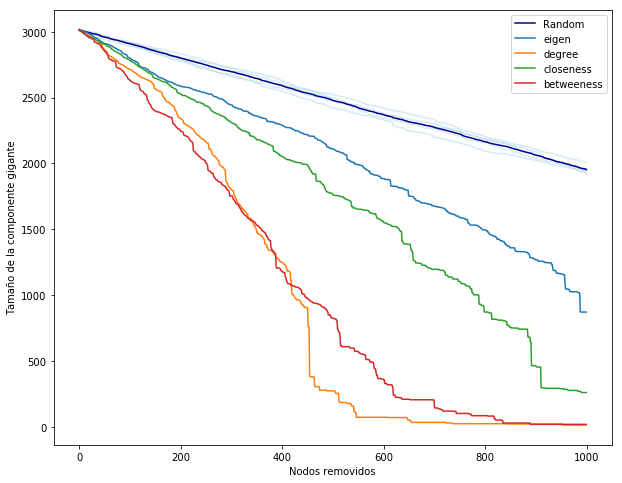

In [94]:
figure(figsize=(10, 8))

for ts in random_ts:
    plot(range(len(ts)), ts, color='lightblue', alpha=0.5)
    
plot(range(len(random_ts_mean)), random_ts_mean, color='darkblue', label='Random')

for name, ts in metrics_ts.items():
    plot(range(len(ts)), ts, label=name)
xlabel('Nodos removidos')
ylabel('Tamaño de la componente gigante')
legend()
plt.show()

En este último gráfico se muestra la evolución del tamaño de la componente gigante cuando se remueven nodos centrales segun diferentes métricas y nodos al azar.

En el caso de _degree_ y _betweeness_ se observa que al remover alrededor de 300 nodos centrales, el tamaño de la componente gigante cae a la mitad (~1500 nodos). Para el caso de _degree_ esta componente empieza a desaparecer más pronunciadamente (500 nodos en la gigante) al remover un poco más de 400 nodos centrales mientras que para _betweeness_ esta situación se da al remover ~ 500 nodos.

Para _closeness_ y _eigenvector_ la caída en el tamaño de la componente gigante no es tan abrupta como en los casos anteriores, lo que indicaría que estas métricas no son tan fuertes como las ya mencionadas (quitar un nodo central según _degree_ desconecta muchos mas nodos que hacerlo con un nodo central según _eigenvector_). Para _closeness_ al remover ~600 nodos se observa una componente gigante de la mitad del tamaño que la original y al eliminar 1000 nodos dicha componente aún posee ~300 nodos. Para _eigenvector_ se necesitan quitar 800 nodos para que su tamaño caiga a la mitad de la componente original y habiendo extraído 1000 nodos centrales su tamaño es también de ~1000.

Finalmente, se observa cómo quitar nodos al azar no afecta de la misma manera (sino de un modo más lento) el tamaño de la componente gigante que quitando nodos centrales con algún criterio métrico: remover nodos azarosamente no destruye, con la misma velocidad que los nodos centrales, las conexiones principales del grafo a tal punto que, incluso habiendo quitado 1000 nodos por azar, la componente gigante continúa teniendo ~2000 nodos.